## Imports

In [1]:
import zipfile
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from datetime import date, timedelta
from datetime import *
from matplotlib import pyplot as plt
from statsmodels.tsa.stattools import coint
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import plot_confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn import metrics

## Getting the data..

In [2]:
# Working with monthly data..
# https://stackoverflow.com/questions/5734438/how-to-create-a-month-iterator
def month_year_iterator(start_year, start_month, end_year, end_month):
    start = 12 * start_year + start_month - 1
    end = 12 * end_year + end_month - 1
    for my in range(start, end):
        m, y = divmod(my, 12)
        yield m, y + 1
        
def retrieve_data(start_date, end_date, symbol):
    temp = 0
    arr = []
    data = pd.DataFrame()
    for i in month_year_iterator(start_date[0], start_date[1], end_date[0], end_date[1]):
        month = str(i[1])
        if int(month) < 10: month = f"0{month}"
        complete_name = f"{symbol}-trades-{i[0]}-{month}"
        try:
            archive = zipfile.ZipFile(complete_name + ".zip", 'r')
        except:
            print(f"File with the name {complete_name}.csv not found. Cycle is stopped.")
            break

        with archive.open(complete_name + ".csv") as datafile:
            df = pd.read_csv(datafile, names=["id", "price", "quantity", "sum", "epoch-time", "maker", "?"])
        df = df.drop(columns=["id", "?", "maker"])
        
        for j in df["price"]:
            if j > temp:
                arr.append(1)
            else:
                arr.append(0)
            temp = j
            
        df['fluctuation'] = arr
        data = data.append(df, ignore_index=True)
        arr = []
    return data

dataold = retrieve_data((2020, 1), (2021, 12), "BTCEUR")

dataold.head()

# data = pd.read_csv('BNBBTC-trades-2021-01.csv', names=["id", "price", "quantity", "sum", "epoch-time", "maker", "?"])
# data = pd.read_csv('BTCEUR-trades-2020-01.csv', names=["id", "price", "quantity", "sum", "epoch-time", "maker", "?"])

,price,quantity,sum,epoch-time,fluctuation
0,6244.33,0.002000,12.488660,1578038400000,1
1,6437.82,0.018748,120.696249,1578038480040,1
2,6433.99,0.045908,295.371613,1578038480040,0
3,6478.91,0.064122,415.440667,1578038594259,1
4,6450.00,0.007310,47.149500,1578040692142,0


In [3]:
data = dataold[:2000000]
data.head()

#pd.options.mode.chained_assignment = None
#data["epoch-time"] = data["epoch-time"].apply(lambda x: pd.to_datetime(datetime.fromtimestamp(x/1000).strftime('%Y-%m-%d %H:%M')))

,price,quantity,sum,epoch-time,fluctuation
0,6244.33,0.002000,12.488660,1578038400000,1
1,6437.82,0.018748,120.696249,1578038480040,1
2,6433.99,0.045908,295.371613,1578038480040,0
3,6478.91,0.064122,415.440667,1578038594259,1
4,6450.00,0.007310,47.149500,1578040692142,0


## Splitting

In [4]:
def split(data, data_percentage, testing_percentage):
    data_size = len(data) 
    size = int(round((data_size * data_percentage), 0))
    #print(size)
    amount = int(round(size*testing_percentage, 0))
    testing = int(size - amount)
    y = data["fluctuation"][:size]
    x = data.drop(columns=["fluctuation"])[:size]
    return x[:amount], x[-testing:], y[:amount], y[-testing:]

X_train,X_test,Y_train,Y_test = train_test_split(data.drop(columns=["fluctuation"]), data["fluctuation"], test_size=0.2, random_state=0, shuffle=True)
X_train_reg,X_test_reg,Y_train_reg,Y_test_reg = train_test_split(data.drop(columns=["price"]), data["price"], test_size=0.2, random_state=0, shuffle=False)

## Some plotting..

<AxesSubplot:xlabel='epoch-time'>

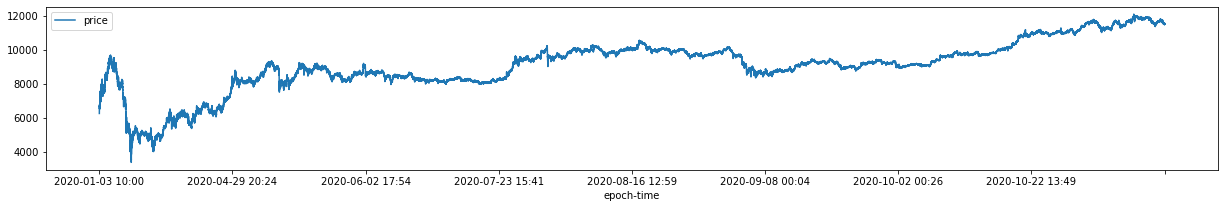

In [5]:
plt.rcParams["figure.figsize"] = (21, 3)
dataforplot = data.copy()
dataforplot["epoch-time"] = dataforplot["epoch-time"].apply(lambda x: datetime.fromtimestamp(x/1000).strftime('%Y-%m-%d %H:%M'))
dataforplot.plot(x = "epoch-time", y = "price")

## Accuracy testing function

In [6]:
def accuracy(test, prediction):
    size = len(test)
    if len(prediction) != size: raise Exception("Testing items must match the prediction items!")
    accuracy = 0

    for i in range(size):
        if round(prediction[i], 2) == test[i]:
            accuracy += 1
    
    return accuracy / size

In [7]:
# Sort dataframe by datetime
def correctdf(data, predict):
    data["predict"] = predict
    data.sort_values(by='epoch-time')
    return data["epoch-time"], data["predict"]

## Linear Regression

In [8]:
linear_regression = LinearRegression().fit(X_train_reg, Y_train_reg)
y_linear_prediction = linear_regression.predict(X_test_reg)
y_linear_prediction = [abs(x) for x in y_linear_prediction.tolist()]
print(y_linear_prediction[:10])

[9897.175681779481, 9934.898425743711, 9881.839439634176, 9917.460090524197, 9882.149237379635, 9918.547579402162, 9882.154709719616, 9882.970739202952, 10030.659420391166, 9882.145680608985]


## Polynomial Regression

In [9]:
polynomial_features = PolynomialFeatures(degree=2, include_bias=True)  # Get features
x_poly = polynomial_features.fit_transform(X_train_reg)
x_test_poly = polynomial_features.transform(X_test_reg)
polynomial_regression = LinearRegression().fit(x_poly, Y_train_reg) # Train model
poly_y_prediction = polynomial_regression.predict(x_test_poly) # Prediction
poly_y_prediction = [abs(x) for x in poly_y_prediction.tolist()]
print(poly_y_prediction[:10])

[9458.879536617547, 9487.13739797473, 9444.550903808326, 9477.843978408724, 9444.837796088308, 9471.857695229352, 9444.842391610146, 9445.604509014636, 9583.984587769955, 9444.828769862652]


## Ridge Regression

In [10]:
#https://machinelearningmastery.com/ridge-regression-with-python/
ridge = Ridge(alpha=1)
ridge.fit(X_train_reg, Y_train_reg)
ridge_y_prediction = ridge.predict(X_test_reg)
ridge_y_prediction = [abs(x) for x in ridge_y_prediction.tolist()]

C:\Users\romet\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=8.8026e-24): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


## Regression model comparisons

In [11]:
df = X_test_reg["epoch-time"].apply(lambda x: pd.to_datetime(datetime.fromtimestamp(x/1000).strftime('%Y-%m-%d %H:%M'))).to_frame()
df, Y_test_reg = correctdf(df, Y_test_reg)

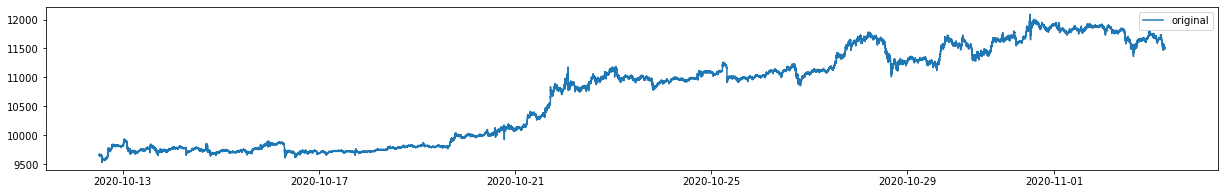

<Figure size 1512x216 with 0 Axes>

In [12]:
plt.plot(df[:1000000], Y_test_reg[:1000000], label = "original")
plt.legend()
plt.show()

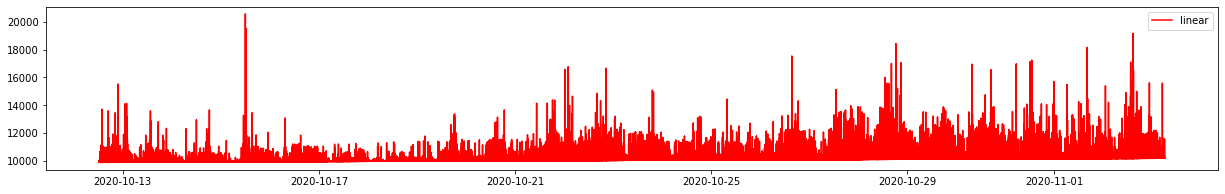

<Figure size 1512x216 with 0 Axes>

In [13]:
plt.plot(df[:1000000], y_linear_prediction[:1000000], label = "linear", color='red')
plt.legend()
plt.show()

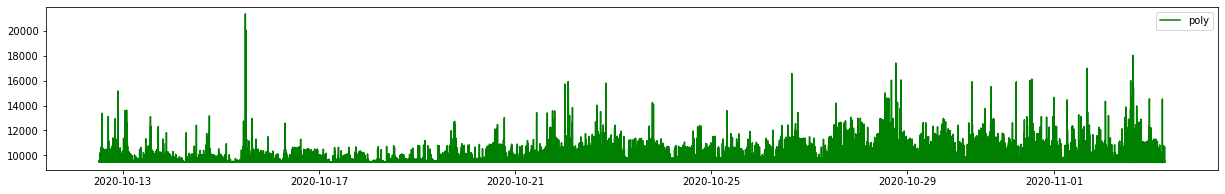

<Figure size 1512x216 with 0 Axes>

In [14]:
plt.plot(df[:1000000], poly_y_prediction[:1000000], label = "poly", color='green')
plt.legend()
plt.show()

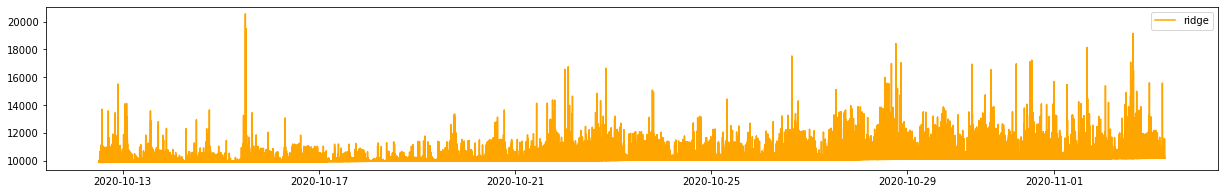

<Figure size 1512x216 with 0 Axes>

In [15]:
plt.plot(df[:1000000], ridge_y_prediction[:1000000], label = "ridge", color='orange')
plt.legend()
plt.show()

## Random Forest Classifier

In [16]:
rf = RandomForestClassifier().fit(X_train, Y_train)
rf_predict = rf.predict(X_test).tolist()

In [17]:
rf_matrix = confusion_matrix(Y_test.tolist(), rf_predict, labels=[1,0])
rf_accuracy = accuracy(Y_test.tolist(), rf_predict)

## KNN

In [18]:
neigh = KNeighborsClassifier(n_neighbors=5)
neigh.fit(X_train, Y_train)
neigh_predict = neigh.predict(X_test).tolist()

In [19]:
neigh_matrix = confusion_matrix(Y_test.tolist(), neigh_predict, labels=[1,0])
neigh_acc = accuracy(Y_test.tolist(), neigh_predict)

## K-Means

In [20]:
kmeans = KMeans(n_clusters=2, random_state=0)
kmeans.fit(X_train, Y_train)
kmeans_predict = kmeans.predict(X_test).tolist()

kmeans_acc = accuracy(Y_test.tolist(), kmeans_predict)
kmmeans_matrix = confusion_matrix(Y_test.tolist(), kmeans_predict, labels=[1,0])

## Accuracy Comparisons Between Classifiers

Random Forest Classifier Confusion Matrix
K Nearest Neighbors Classifier Confusion Matrix


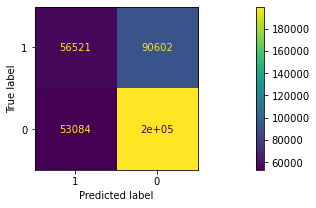

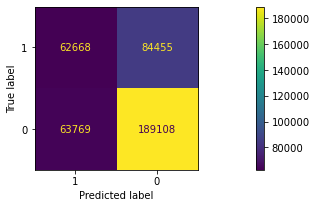

In [21]:
print("Random Forest Classifier Confusion Matrix")
plot_confusion_matrix(rf, X_test, Y_test, labels=[1,0])

print("K Nearest Neighbors Classifier Confusion Matrix")
plot_confusion_matrix(neigh, X_test, Y_test, labels=[1,0])

<BarContainer object of 3 artists>

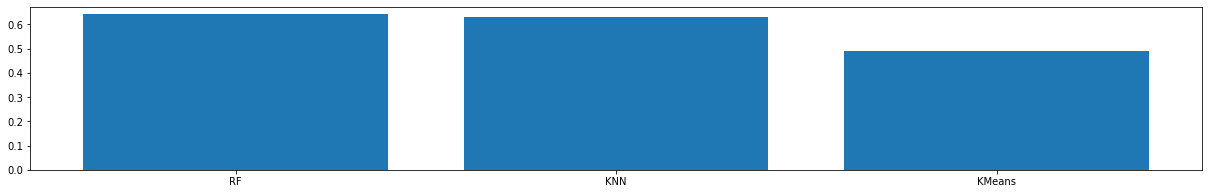

In [106]:
# Classification accuracy values
c_acc = [rf_accuracy, neigh_acc, kmeans_acc]
c_names = ['RF', 'KNN', 'KMeans']
plt.bar(c_names, c_acc)

## Determing the cointegration between two specific crypto currencies (ETH - BTC)? (+ graphs)

In [22]:
#https://stackoverflow.com/questions/11362943/efficient-cointegration-test-in-python
databtc = dataold[:2000000]
dataeth = retrieve_data((2020, 1), (2021, 11), "ETHEUR")[:2000000]

In [23]:
databtc = data[:len(dataeth)]

## Correlation between BTC - ETH

In [96]:
databtc.corrwith(dataeth, axis = 0)

price          0.810345
quantity       0.001686
sum            0.002449
epoch-time     0.880583
fluctuation    0.004523
dtype: float64

In [103]:
# BTC self correlation
corr1 = databtc.corr()
corr1.style.background_gradient(cmap='coolwarm')

,price,quantity,sum,epoch-time,fluctuation
price,1.000000,-0.012046,0.044571,0.812607,0.049340
quantity,-0.012046,1.000000,0.980077,0.002350,-0.043577
sum,0.044571,0.980077,1.000000,0.048198,-0.041066
epoch-time,0.812607,0.002350,0.048198,1.000000,0.058386
fluctuation,0.049340,-0.043577,-0.041066,0.058386,1.000000


In [105]:
# ETH self correlation
corr2 = dataeth.corr()
corr2.style.background_gradient(cmap='coolwarm')

,price,quantity,sum,epoch-time,fluctuation
price,1.000000,-0.060844,0.050067,0.895985,0.043393
quantity,-0.060844,1.000000,0.948346,-0.064205,-0.043921
sum,0.050067,0.948346,1.000000,0.040283,-0.040230
epoch-time,0.895985,-0.064205,0.040283,1.000000,0.044302
fluctuation,0.043393,-0.043921,-0.040230,0.044302,1.000000


## Monthly price mean value correlation

In [57]:
groupedBtc = databtc.copy()
groupedBtc['epoch-time'] = groupedBtc["epoch-time"].apply(lambda x: pd.to_datetime(datetime.fromtimestamp(x/1000).strftime('%Y-%m')).month).to_frame()

groupedEth = dataeth.copy()
groupedEth['epoch-time'] = groupedEth["epoch-time"].apply(lambda x: pd.to_datetime(datetime.fromtimestamp(x/1000).strftime('%Y-%m')).month).to_frame()

In [58]:
groupedBtc = groupedBtc.groupby(groupedBtc['epoch-time'])
groupedEth = groupedEth.groupby(groupedEth['epoch-time'])

In [92]:
groupedBtcMean = pd.DataFrame(groupedBtc['price'].mean())
groupedEthMean = pd.DataFrame(groupedEth['price'].mean())

In [95]:
groupedBtcMean.corrwith(groupedEthMean, axis = 0)

price    0.926477
dtype: float64